In [1]:
TRAIN = 0
REBUILD_DATA = 0

TRAIN_CSV = 'train_combined_poses.csv'
TEST_CSV = 'test_combined_poses.csv'

MODEL_ARCH_FILE = 'model_5l_combined_poses.json'
MODEL_WEIGHTS = 'model_5l_weight_ep50_combined_poses.hdf5'
TRAINING_HIST = 'training_his_combined_poses.pickle'

train_data_path = 'train_data_abcde_combined_poses.npy'
train_label_path = 'train_label_abcde_combined_poses.npy'
test_data_path = 'test_data_abcde_combined_poses.npy'
test_label_path = 'test_label_abcde_combined_poses.npy'

path = ''
# img_w = 512
# img_w = 424
img_w = 128
img_h = 128

n_labels = 2

kernel = 3

n_train = 24500
n_test = 10500

# SegNet model implemented with keras

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd

import sys

from skimage.io import imread
from skimage.transform import resize
from skimage import color

from matplotlib import pyplot as plt

import os

from tensorflow.contrib.keras.python.keras import models
from tensorflow.contrib.keras.python.keras.optimizers import SGD, Adam
from tensorflow.contrib.keras.python.keras.models import model_from_json
from tensorflow.contrib.keras.python.keras.callbacks import EarlyStopping

# Build model
from tensorflow.contrib.keras.python.keras.layers.core import Activation, Reshape, Permute
from tensorflow.contrib.keras.python.keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.contrib.keras.python.keras.layers import Dropout
from tensorflow.contrib.keras.python.keras.layers.normalization import BatchNormalization

from tensorflow.contrib.keras.python.keras.utils.vis_utils import plot_model

import json

import pickle

from IPython.display import clear_output

import time

import cv2

### Utility functions

In [3]:
def label_map(labels):
    label_map = np.zeros([img_h, img_w, n_labels])    
    for r in range(img_h):
        for c in range(img_w):
            label_map[r, c, int(np.ceil(labels[r][c]))] = 1
    return label_map

In [4]:
def prep_data(mode):
    assert mode in {'test', 'train'}, \
        'mode should be either \'test\' or \'train\''
    data = []
    label = []
    if mode == 'train':
        df = pd.read_csv(path + TRAIN_CSV)
    else:
        df = pd.read_csv(path + TEST_CSV)
        
    n = n_train if mode == 'train' else n_test
    for i, item in df.iterrows():
        if i >= n:
            break
        img, gt = [resize(imread(path + item[0]), (img_h, img_w))], resize(np.clip(~(imread(path + item[1])[:, :, 0]), 0, 1), (img_h, img_w))
        
        data.append(img)
        label.append(label_map(gt))
        sys.stdout.write('\r')
        sys.stdout.write(mode + ": [%-20s] %d%%" % ('=' * int(20. * (i + 1) / n - 1) + '>',
                                                    int(100. * (i + 1) / n)))
        sys.stdout.flush()
    sys.stdout.write('\r')
    sys.stdout.flush()
    data, label = np.array(data).swapaxes(1, 3), np.array(label).reshape((n, img_h * img_w, n_labels))

    print(mode + ': OK')
    print('\tshapes: {}, {}'.format(data.shape, label.shape))
    print('\ttypes:  {}, {}'.format(data.dtype, label.dtype))
    print('\tmemory: {}, {} MB'.format(data.nbytes / 1048576, label.nbytes / 1048576))

    return data, label

In [5]:
def plot_results_2(output, indx):
    df = pd.read_csv(path + TEST_CSV)
    
    n_test_imgs = indx.shape[0]
    plt.figure(figsize=(15, 2 * n_test_imgs))
    
    subplot_indx = 0
    for cur_indx in indx:
        for i, item in df.iterrows():
            if i == cur_indx:
                plt.subplot(n_test_imgs, 5, 5 * subplot_indx + 1)
                plt.title('Input Image')
                plt.axis('off')
                im = resize(imread(path + item[0]), (img_h, img_w))
                plt.imshow(im, cmap='gray')

                plt.subplot(n_test_imgs, 5, 5 * subplot_indx + 2)
                plt.title('Ground Truth')
                plt.axis('off')
                gt = resize(np.clip(~(imread(path + item[1])[:, :, 0]), 0, 1), (img_h, img_w))
                plt.imshow(np.clip(gt, 0, 1), cmap='gray')

                plt.subplot(n_test_imgs, 5, 5 * subplot_indx + 3)
                plt.title('Prediction')
                plt.axis('off')
                labeled = np.argmax(output[subplot_indx], axis=-1)
                plt.imshow(labeled, cmap='gray')

                plt.subplot(n_test_imgs, 5, 5 * subplot_indx + 4)
                plt.title('Heat map')
                plt.axis('off')
                plt.imshow(output[subplot_indx][:, :, 1])

                plt.subplot(n_test_imgs, 5, 5 * subplot_indx + 5)
                plt.title('Comparison')
                plt.axis('off')
                rgb = np.empty((img_h, img_w, 3))
                rgb[:, :, 0] = labeled
                img = resize(imread(path + item[0]), (img_h, img_w))
                rgb[:, :, 1] = img
                rgb[:, :, 2] = gt
                plt.imshow(rgb)

                subplot_indx += 1

                break

#     plt.savefig('result.png')
    plt.show()

### Build Model

In [6]:
if os.path.isfile(MODEL_ARCH_FILE):
    print('Loading model...', end='')
    with open(MODEL_ARCH_FILE, 'r') as f:
        json_string = f.read()
    autoencoder = model_from_json(json_string)
    print('done.')
else:
    print('Defining model...', end='')
    encoding_layers = [
        Conv2D(64, (kernel, kernel), padding='same', input_shape=(img_h, img_w, 1)),
        BatchNormalization(),
        Activation('relu'),
        Conv2D(64, (kernel, kernel), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(),

        Conv2D(128, (kernel, kernel), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        Conv2D(128, (kernel, kernel), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(),

        Conv2D(256, (kernel, kernel), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        Conv2D(256, (kernel, kernel), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        Conv2D(256, (kernel, kernel), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(),

        Conv2D(512, (kernel, kernel), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        Conv2D(512, (kernel, kernel), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        Conv2D(512, (kernel, kernel), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(),

        Conv2D(512, (kernel, kernel), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        Conv2D(512, (kernel, kernel), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        Conv2D(512, (kernel, kernel), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(),
    ]

    autoencoder = models.Sequential()
    autoencoder.encoding_layers = encoding_layers

    for l in autoencoder.encoding_layers:
        autoencoder.add(l)

    decoding_layers = [
        UpSampling2D(),
        Conv2D(512, (kernel, kernel), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        Conv2D(512, (kernel, kernel), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        Conv2D(512, (kernel, kernel), padding='same'),
        BatchNormalization(),
        Activation('relu'),

        UpSampling2D(),
        Conv2D(512, (kernel, kernel), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        Conv2D(512, (kernel, kernel), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        Conv2D(256, (kernel, kernel), padding='same'),
        BatchNormalization(),
        Activation('relu'),

        UpSampling2D(),
        Conv2D(256, (kernel, kernel), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        Conv2D(256, (kernel, kernel), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        Conv2D(128, (kernel, kernel), padding='same'),
        BatchNormalization(),
        Activation('relu'),

        UpSampling2D(),
        Conv2D(128, (kernel, kernel), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        Conv2D(64, (kernel, kernel), padding='same'),
        BatchNormalization(),
        Activation('relu'),

        UpSampling2D(),
        Conv2D(64, (kernel, kernel), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        Conv2D(n_labels, (1, 1), padding='valid'),
        BatchNormalization(),
    ]
    autoencoder.decoding_layers = decoding_layers
    for l in autoencoder.decoding_layers:
        autoencoder.add(l)

    autoencoder.add(Reshape((n_labels, img_h * img_w)))
    autoencoder.add(Permute((2, 1)))
    autoencoder.add(Activation('softmax'))

    with open(MODEL_ARCH_FILE, 'w') as outfile:
        outfile.write(json.dumps(json.loads(autoencoder.to_json()), indent=2))
    
    print('done.')

Loading model...done.


In [7]:
print(autoencoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 64)      640       
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
activation_2 (Activation)    (None, 128, 128, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
__________

### Loading and compiling model built with *'build_model.py'*

In [8]:
print('Compiling model...', end='')
# optimizer = SGD(lr=0.001, momentum=0.9, decay=0.0005, nesterov=False)
optimizer = Adam(lr=0.001, decay=0.0005)
autoencoder.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])
print('done.')

Compiling model...done.


### Data

In [9]:
if os.path.isfile(train_data_path) and os.path.isfile(train_label_path) and REBUILD_DATA == 0:
    print('Loading training data...', end='')
    train_data = np.load(train_data_path)
    train_label = np.load(train_label_path)
    print('done.')
else:
    train_data, train_label = prep_data('train')
    np.save(train_data_path, train_data)
    np.save(train_label_path, train_label)

if os.path.isfile(test_data_path) and os.path.isfile(test_label_path) and REBUILD_DATA == 0:
    print('Loading testing data...', end='')
    test_data = np.load(test_data_path)
    test_label = np.load(test_label_path)
    print('done.')
else:
    test_data, test_label = prep_data('test')
    np.save(test_data_path, test_data)
    np.save(test_label_path, test_label)

train: OK==================>] 100%
	shapes: (24500, 128, 128, 1), (24500, 16384, 2)
	types:  float64, float64
	memory: 3062.5, 6125.0 MB
test: OK==================>] 100%
	shapes: (10500, 128, 128, 1), (10500, 16384, 2)
	types:  float64, float64
	memory: 1312.5, 2625.0 MB


### Train model or load existing weights

In [10]:
if TRAIN == 1:
    start_time = time.time()
    
    nb_epoch = 20
    batch_size = 8

    early_stopping = EarlyStopping(monitor='val_loss', verbose=1, patience=5)

    history = autoencoder.fit(train_data, train_label,
                              batch_size=batch_size, epochs=nb_epoch,
                              verbose=1,
                              validation_data=(test_data, test_label),
                              callbacks=[early_stopping])
    
    training_time = time.time() - start_time
    print('> Training time on GTX1080: ' + str(training_time) + ' sec')

    # Save trained model
    autoencoder.save_weights(MODEL_WEIGHTS)
    
    # Save training history
    with open(TRAINING_HIST, 'wb') as f:
        pickle.dump(history.history, f)
        
    history_ = history.history
else:
    # Load trained model
    autoencoder.load_weights(MODEL_WEIGHTS)
    
    # Load training history
    file = open(TRAINING_HIST, 'rb')
    history_ = pickle.load(file)

Train on 24500 samples, validate on 10500 samples
Epoch 1/20
24500/24500 [==============================] - 981s - loss: 0.0969 - acc: 0.9681 - val_loss: 0.0555 - val_acc: 0.9796
Epoch 2/20
24500/24500 [==============================] - 739s - loss: 0.0454 - acc: 0.9829 - val_loss: 0.0386 - val_acc: 0.9850
Epoch 3/20
24500/24500 [==============================] - 744s - loss: 0.0337 - acc: 0.9867 - val_loss: 0.0309 - val_acc: 0.9874
Epoch 4/20
24500/24500 [==============================] - 781s - loss: 0.0277 - acc: 0.9888 - val_loss: 0.0259 - val_acc: 0.9895
Epoch 5/20
24500/24500 [==============================] - 773s - loss: 0.0239 - acc: 0.9903 - val_loss: 0.0225 - val_acc: 0.9909
Epoch 6/20
24500/24500 [==============================] - 739s - loss: 0.0216 - acc: 0.9912 - val_loss: 0.0207 - val_acc: 0.9916
Epoch 7/20
24500/24500 [==============================] - 739s - loss: 0.0197 - acc: 0.9919 - val_loss: 0.0199 - val_acc: 0.9919
Epoch 8/20
24500/24500 [=======================

### Model visualization

In [11]:
# plot_model(autoencoder, to_file='model.png', show_shapes=True)

### Load testing data and evaluate score

In [12]:
score = autoencoder.evaluate(test_data, test_label, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

# score = autoencoder.evaluate(train_data, train_label, verbose=0)
# print('Train score:', score[0])
# print('Train accuracy:', score[1])

10496/10500 [============================>.] - ETA: 0sTest score: 0.0141316837427
Test accuracy: 0.994364478702


### Visualizing results

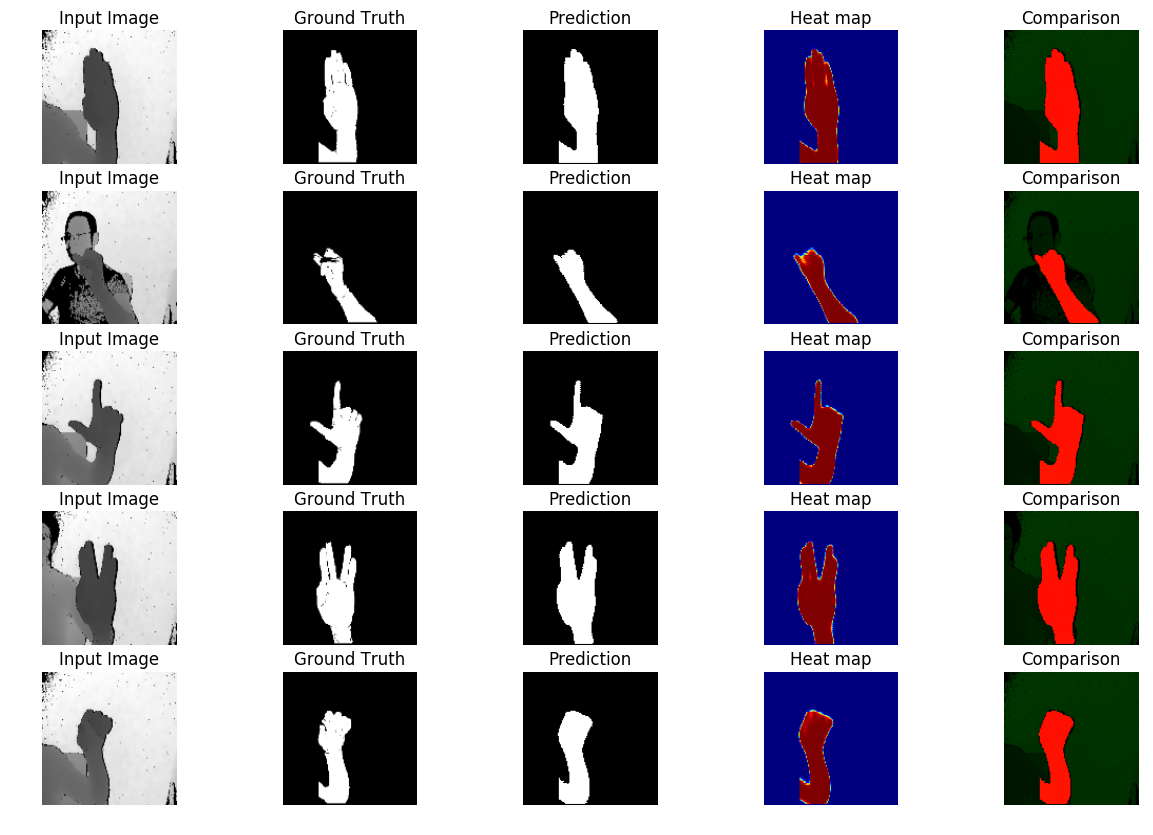

In [13]:
testing_indx = np.random.choice(n_test, 5)

test_ite = test_data[testing_indx, :, :, :]
# test_ite = np.expand_dims(test_ite, axis=0)

output = autoencoder.predict_proba(test_ite, verbose=0)
output = output.reshape((output.shape[0], img_h, img_w, n_labels))

plot_results_2(output, testing_indx)

# Training summary

dict_keys(['loss', 'val_acc', 'val_loss', 'acc'])


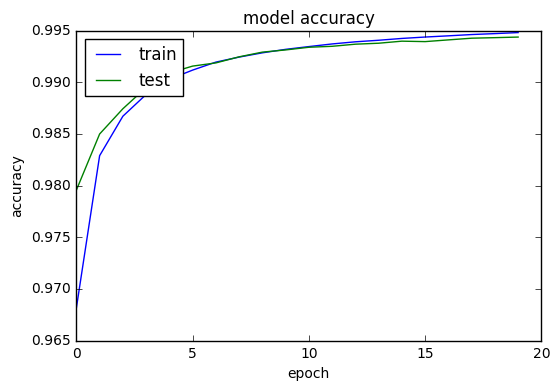

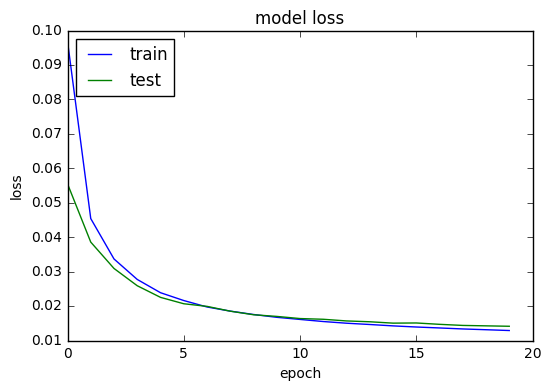

In [14]:
# list all data in history
print(history_.keys())
# summarize history for accuracy
plt.plot(history_['acc'])
plt.plot(history_['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_['loss'])
plt.plot(history_['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Realtime visualization

In [15]:
# # test_data, test_label = prep_data('test')

# df = pd.read_csv(path + TEST_CSV)

# n_test_imgs = 1
# n_type_outputs = 3

# for i, item in df.iterrows():
#     clear_output(wait=True)
    
#     # Call trained model
#     test_ite = test_data[i, :, :, :]
#     test_ite = np.expand_dims(test_ite, axis=0)
#     start_time = time.time()
#     output = autoencoder.predict_proba(test_ite, verbose=0)
#     pred_time = time.time() - start_time
#     output = output.reshape((output.shape[0], img_h, img_w, n_labels))
    
#     # Load input image
#     im = resize(imread(path + item[0]), (img_h, img_w))

#     #
#     rgb = np.empty((img_h, img_w, 3))
#     labeled = np.argmax(output[0], axis=-1)
#     img = resize(imread(path + item[0]), (img_h, img_w))
#     rgb[:, :, 0] = img
#     rgb[:, :, 1] = img + labeled
#     rgb[:, :, 2] = img

#     rgb = cv2.resize(rgb, (256, 213))
    
#     cv2.imshow('hand segmentation', rgb)
#     print('FPS: ' + str(int(1.0/pred_time)))
    
#     k = cv2.waitKey(30) & 0xff
#     if k == 27:     # Esc
#         cv2.destroyAllWindows()
#         break

In [16]:
# def plot_results(output):
#     gt = []
#     df = pd.read_csv(path + 'test.csv')
#     for i, item in df.iterrows():
#         gt.append(np.clip(imread(path + item[1]), 0, 1))

#     plt.figure(figsize=(15, 2 * n_test))
#     for i, item in df.iterrows():
#         if i > 3:
#             break
#         plt.subplot(n_test, 5, 5 * i + 1)
#         plt.title('Input Image')
#         plt.axis('off')
# #         im = imread(path + item[0])
#         im = resize(imread(path + item[0]), (img_h, img_w))
#         plt.imshow(im, cmap='gray')
        
#         plt.subplot(n_test, 5, 5 * i + 2)
#         plt.title('Ground Truth')
#         plt.axis('off')
# #         gt = imread(path + item[1])
#         gt = resize(np.clip(~(imread(path + item[1])[:, :, 0]), 0, 1), (img_h, img_w))
#         plt.imshow(np.clip(gt, 0, 1), cmap='gray')

#         plt.subplot(n_test, 5, 5 * i + 3)
#         plt.title('Prediction')
#         plt.axis('off')
#         labeled = np.argmax(output[i], axis=-1)
#         plt.imshow(labeled, cmap='gray')

#         plt.subplot(n_test, 5, 5 * i + 4)
#         plt.title('Heat map')
#         plt.axis('off')
#         plt.imshow(output[i][:, :, 1])

#         plt.subplot(n_test, 5, 5 * i + 5)
#         plt.title('Comparison')
#         plt.axis('off')
#         rgb = np.empty((img_h, img_w, 3))
#         rgb[:, :, 0] = labeled
#         img = resize(imread(path + item[0]), (img_h, img_w))
#         rgb[:, :, 1] = img
#         rgb[:, :, 2] = gt
#         plt.imshow(rgb)

#     plt.savefig('result.png')
#     plt.show()